# Ast502 - Lecture 8: Markov Chain Monte Carlo (MCMC)
## Nico Garavito - Camargo

## References:

- ARAA (Sharma, S): [Markov Chain Monte Carlo Methods for Bayesian Data Analysis in Astronomy](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1706.01629)

- Ivezic Chapter 5.8 

- [uw-astr-324MCMC](https://github.com/uw-astr-324-s17/astr-324-s17/blob/master/notebooks/Week-5-Tue.ipynb)
- [uw-astr-324-MCMCII](https://github.com/uw-astr-324-s17/astr-324-s17/blob/master/notebooks/Week-5-Thu.ipynb)

http://www.mcmchandbook.net/HandbookTableofContents.html

## Dependencies: 
- pymc (Metropolis - Hastings)

```
git clone https://github.com/pymc-devs/pymc.git

python setup.py config_fc --fcompiler gfortran build

python setup.py install
```


- emcee (Affine invariant MCMC) http://dfm.io/emcee/current/  
```
pip install emcee
```
- bmcmc : (metropolis - Hastings & Gibbs) http://bmcmc.readthedocs.io/en/latest/  
```
pip install bmcmc
```


-------------------------

Given the outcome of an experiment (observations) what are the **causes**, or what is the **probability** of a cause compared to some other cuase? If we
have some **prior** information, how does that help us?

Cuases : Model + parameters

Probasbility : PDF of the parameters in my model

Prior : Previous knowledge of the measurements (See $\S$ 2.3 in Sharma, S. 2017) 

## Monte Carlo Methods:

How to efficiently sample the PDF of parameters of a given a data set.

Generate a random set of $M$ values $\theta$ unifmormely sampled over the integration volume

## Markov Chains

 The values of $\theta$ are not sampled uniformly from the integration volume, they are sampled proportionally to $p(\theta)$!
 
  "Sequence of random variables $\theta$ where a given variable not trivially depends **only on its preceding value**"

### Properties:

Condition of detailed balance:

\begin{equation}
P(\theta_{i+1}| \theta_{i}) = P(\theta_{i}| \theta_{i+1})  
\end{equation}

Tranisition probability 

\begin{equation}
T(\theta_{i+1} | \theta_i) = P(\theta_{i+1}| \theta_{i})
\end{equation}



## Markov Chain - Montecarlo MCMC.

Sample the PDF of parameters of a given a data set using Markov chains.


## Metropolis - Hastings

\begin{equation}
T(\theta_{i+1} | \theta_i) = \dfrac{K(\theta_i | \theta_{i+1}) p(\theta_{i+1})}{K(\theta_{i+1} | \theta_{i}) p(\theta_{i})}
\end{equation}

- $K_{\theta}$ is a proposed distribution function (*usually a Gaussian. Therefore, it is symmetric and: * $K(\theta_i | \theta_{i+1}) = K(\theta_{i+1} | \theta_{i})$). 

- $p(\theta_i)$ is the likelihood of $\theta_i$.



 

## Burning phase:

The Markov chain take a number steps to reach a stationary distribution. The steps to reach
this condition need to be discarded or **burned**. 

- "Gelman and Rubin proposed to generate a number of chains
and then compare the ratio of the variance between the chains to the mean variance
within the chains (this ratio is known as the R statistic). For stationary chains,
this ratio will be close to 1."
- Autocorrelation function can be used to estimate the requiered number of steps to sample the PDF.



In [1]:
%pylab inline
from IPython.display import HTML

font = {'size':18, 'family':'serif'}
matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


In [40]:
def likelihood(x):
    """
    Likelihood function:
    
    """
    x_1 = 1.0
    sigma_1 = 0.1
    L = 1  / (2*np.pi*sigma_1**2.0) * np.exp(-(x - x_1)**2.0/(sigma_1**2.0)) 
    return L

In [41]:
def MCMC(N_points, sigma_q):
    """
    A simple 1D MCMC using the symmetric 
    (K(\theta_{i+1} | \theta_{i}) = K(\theta_{i} | \theta_{i+1})) 
    Metropolis algorithm.
    
    parameters:
    -----------
    
    N_points : int
        lenght of the markov chain
        
    sigma_q : float
        dispersion of the gaussian distribution, this is the lenght of the
        step in the markov chain.
        
    """
    ## Arrays to store the likelihood estimates and 
    y = np.zeros(N_points)
    x = np.zeros(N_points)
    acept = 0
    x[0] = 1.0
    y[0] = likelihood(x[0])
    
    # Markov Chain iteration.
    for i in range(1,N_points):
        # K(\theta_{i+1} | \theta_{i})
        x_new = np.random.normal(x[i-1], sigma_q)
        # Evaluate the likelihood!
        y_new = likelihood(x_new)
        # p(\theta_{i+1}) / p(\theta_{i})
        R = y_new/y[i-1]
        
        ## Acceptance - Rejection decission.
        if R>=1.0:
            x[i] = x_new
            y[i] = likelihood(x_new)
            acept +=1
        else:
            # Random number between 0 and 1
            P = random.random(1)
            if P < R:
                x[i] = x_new
                y[i] = likelihood(x_new)
                acept +=1
            else:
                x[i] = x[i-1]
                y[i] = likelihood(x[i-1])
    return x, y, acept


Acceptance ratio =  0.9509


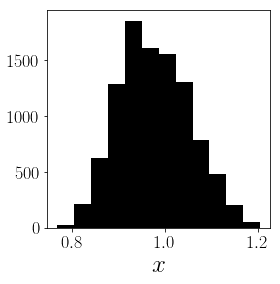

In [42]:
N_steps = 10000
sigma = 0.01
x_mcmc, y_mcmc, acpt = MCMC(N_steps, sigma)
print('Acceptance ratio = ', acpt/float(N_steps))

figure(figsize=(4,4))
hist(x_mcmc, color='k', bins=12)
xlabel('$x$', fontsize=25)

##  Sampling a Gaussian function with pymc

In [7]:
import numpy as np
import pymc
# generate random Gaussian data with mu=0, sigma=1
N = 100
x = np.random.normal(size=N)

# define the MCMC model: uniform prior on mu ,
# fixed (known) sigma
mu = pymc.Uniform('mu', -5, 5)
sigma = 1

M = pymc.Normal('M', mu , sigma , observed=True, value=x)
model = dict(M=M, mu=mu)
# run the model , and get the trace of mu
S = pymc.MCMC(model)
S.sample(10000, burn=1000)
mu_sample = S.trace('mu')[:]
# print the MCMC estimate
print('')
print("Bayesian (MCMC): %.3f +/- %.3f"
% (np.mean(mu_sample), np.std(mu_sample)))
# compare to the frequentist estimate
print("Frequentist: %.3f +/- %.3f" % (np.mean(x), np.std(x, ddof=1) / np.sqrt(N)))

 [-----------------100%-----------------] 10000 of 10000 complete in 0.3 sec
Bayesian (MCMC): 0.050 +/- 0.098
Frequentist: 0.055 +/- 0.107


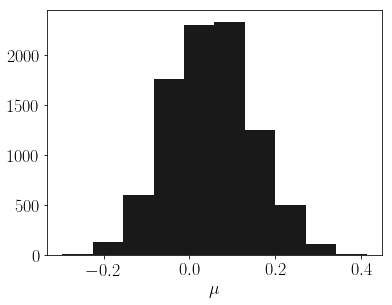

In [46]:
figure(figsize=(6,4.5))
hist(mu_sample, color='k', alpha=0.9)
xlabel('$\mu$')

## Metropolis Hastings : Sampling 

 [-----------------100%-----------------] 50000 of 50000 complete in 2.9 sec

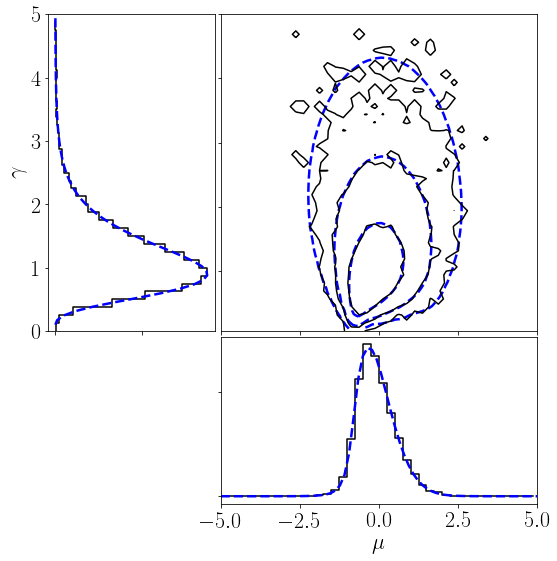

In [47]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import cauchy
#from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=22, usetex=True)


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


#----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC:

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)


@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
# Burning the chain first 5000 steps
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

#----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 8))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed', linewidths=2.5)

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b', lw=2.5)
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma 
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b', lw=2.5)
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

## Metropolis Hastings : Model Selection

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)


 [-----------------100%-----------------] 10000 of 10000 complete in 70.6 sec

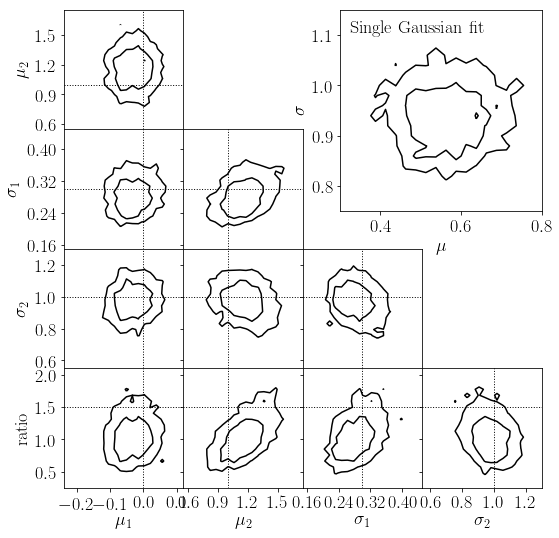

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from scipy.special import gamma
from scipy.stats import norm
from sklearn.neighbors import BallTree
from astroML.density_estimation import GaussianMixture1D
from astroML.plotting import plot_mcmc
# hack to fix an import issue in older versions of pymc
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)


def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[:] for s in S.stochastics])
    logp = np.zeros(traces.shape[1])
    for i in range(len(logp)):
        logp[i] = -M.func(traces[:, i])
    return logp


def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


#------------------------------------------------------------
# Generate the data
mu1_in = 0
sigma1_in = 0.3
mu2_in = 1
sigma2_in = 1
ratio_in = 1.5
N = 200

np.random.seed(10)
gm = GaussianMixture1D([mu1_in, mu2_in],
                       [sigma1_in, sigma2_in],
                       [ratio_in, 1])
x_sample = gm.sample(N)

#------------------------------------------------------------
# Set up pyMC model: single gaussian
#  2 parameters: (mu, sigma)
M1_mu = pymc.Uniform('M1_mu', -5, 5, value=0)
M1_log_sigma = pymc.Uniform('M1_log_sigma', -10, 10, value=0)


@pymc.deterministic
def M1_sigma(M1_log_sigma=M1_log_sigma):
    return np.exp(M1_log_sigma)


@pymc.deterministic
def M1_tau(M1_sigma=M1_sigma):
    return 1. / M1_sigma ** 2

M1 = pymc.Normal('M1', M1_mu, M1_tau, observed=True, value=x_sample)
model1 = dict(M1_mu=M1_mu, M1_log_sigma=M1_log_sigma,
              M1_sigma=M1_sigma,
              M1_tau=M1_tau, M1=M1)


#------------------------------------------------------------
# Set up pyMC model: double gaussian
#  5 parameters: (mu1, mu2, sigma1, sigma2, ratio)

def doublegauss_like(x, mu1, mu2, sigma1, sigma2, ratio):
    """log-likelihood for double gaussian"""
    r1 = ratio / (1. + ratio)
    r2 = 1 - r1
    L = r1 * norm(mu1, sigma1).pdf(x) + r2 * norm(mu2, sigma2).pdf(x)
    L[L == 0] = 1E-16  # prevent divide-by-zero error
    logL = np.log(L).sum()
    if np.isinf(logL):
        raise pymc.ZeroProbability
    else:
        return logL


def rdoublegauss(mu1, mu2, sigma1, sigma2, ratio, size=None):
    """random variable from double gaussian"""
    r1 = ratio / (1. + ratio)
    r2 = 1 - r1
    R = np.asarray(np.random.random(size))

    Rshape = R.shape
    R = np.atleast1d(R)

    mask1 = (R < r1)
    mask2 = ~mask1
    N1 = mask1.sum()
    N2 = R.size - N1

    R[mask1] = norm(mu1, sigma1).rvs(N1)
    R[mask2] = norm(mu2, sigma2).rvs(N2)

    return R.reshape(Rshape)

DoubleGauss = pymc.stochastic_from_dist('doublegauss',
                                        logp=doublegauss_like,
                                        random=rdoublegauss,
                                        dtype=np.float,
                                        mv=True)

# set up our Stochastic variables, mu1, mu2, sigma1, sigma2, ratio
M2_mu1 = pymc.Uniform('M2_mu1', -5, 5, value=0)
M2_mu2 = pymc.Uniform('M2_mu2', -5, 5, value=1)

M2_log_sigma1 = pymc.Uniform('M2_log_sigma1', -10, 10, value=0)
M2_log_sigma2 = pymc.Uniform('M2_log_sigma2', -10, 10, value=0)


@pymc.deterministic
def M2_sigma1(M2_log_sigma1=M2_log_sigma1):
    return np.exp(M2_log_sigma1)


@pymc.deterministic
def M2_sigma2(M2_log_sigma2=M2_log_sigma2):
    return np.exp(M2_log_sigma2)

M2_ratio = pymc.Uniform('M2_ratio', 1E-3, 1E3, value=1)

M2 = DoubleGauss('M2', M2_mu1, M2_mu2, M2_sigma1, M2_sigma2, M2_ratio,
                 observed=True, value=x_sample)

model2 = dict(M2_mu1=M2_mu1, M2_mu2=M2_mu2,
              M2_log_sigma1=M2_log_sigma1, M2_log_sigma2=M2_log_sigma2,
              M2_sigma1=M2_sigma1, M2_sigma2=M2_sigma2,
              M2_ratio=M2_ratio, M2=M2)


#------------------------------------------------------------
# Set up MCMC sampling
def compute_MCMC_models(Niter=10000, burn=1000, rseed=0):
    pymc.numpy.random.seed(rseed)

    S1 = pymc.MCMC(model1)
    S1.sample(iter=Niter, burn=burn)
    trace1 = np.vstack([S1.trace('M1_mu')[:],
                        S1.trace('M1_sigma')[:]])
    logp1 = get_logp(S1, model1)

    S2 = pymc.MCMC(model2)
    S2.sample(iter=Niter, burn=burn)
    trace2 = np.vstack([S2.trace('M2_mu1')[:],
                        S2.trace('M2_mu2')[:],
                        S2.trace('M2_sigma1')[:],
                        S2.trace('M2_sigma2')[:],
                        S2.trace('M2_ratio')[:]])
    logp2 = get_logp(S2, model2)

    return trace1, logp1, trace2, logp2

trace1, logp1, trace2, logp2 = compute_MCMC_models()


#------------------------------------------------------------
# Compute Odds ratio with density estimation technique
BF1, dBF1 = estimate_bayes_factor(trace1, logp1, r=0.02)
BF2, dBF2 = estimate_bayes_factor(trace2, logp2, r=0.05)


#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))

labels = [r'$\mu_1$',
          r'$\mu_2$',
          r'$\sigma_1$',
          r'$\sigma_2$',
          r'${\rm ratio}$']

true_values = [mu1_in,
               mu2_in,
               sigma1_in,
               sigma2_in,
               ratio_in]

limits = [(-0.24, 0.12),
          (0.55, 1.75),
          (0.15, 0.45),
          (0.55, 1.3),
          (0.25, 2.1)]

# we assume mu1 < mu2, but the results may be switched
#  due to the symmetry of the problem.  If so, switch back
if np.median(trace2[0]) > np.median(trace2[1]):
    trace2 = trace2[[1, 0, 3, 2, 4], :]
    N2_norm_mu = N2.mu[N2.M2_mu2, N2.M2_mu1,
                       N2.M2_sigma2, N2.M2_sigma1, N2.M2_ratio]
    N2_norm_Sig = N2.C[N2.M2_mu2, N2.M2_mu1,
                       N2.M2_sigma2, N2.M2_sigma1, N2.M2_ratio]

# Plot the simple 2-component model
ax, = plot_mcmc(trace1, fig=fig, bounds=[0.6, 0.6, 0.95, 0.95],
                limits=[(0.3, 0.8), (0.75, 1.15)],
                labels=[r'$\mu$', r'$\sigma$'], colors='k')

ax.text(0.05, 0.95, "Single Gaussian fit", va='top', ha='left',
        transform=ax.transAxes)

# Plot the 5-component model
ax_list = plot_mcmc(trace2, limits=limits, labels=labels,
                    true_values=true_values, fig=fig,
                    bounds=(0.12, 0.12, 0.95, 0.95),
                    colors='k')
for ax in ax_list:
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(plt.MaxNLocator(4))

plt.show()

## Limitations of Metropolis

If the parameters of your model are correlated the Metroplis-Hasting sampling is not the most efficient. 
Large $\sigma$ produce many rejections and a small $\sigma$ is not efficient.

- How to choose sigma? 
- Where to start the chain : Try to have a good guess by minimizing the likelihood function.


In [12]:
HTML('<iframe src="https://vimeo.com/22616409" width="700" height="394" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe><p><a href="https://vimeo.com/22616409">MCMC banana shape</a> from <a href="https://vimeo.com/22616409">MCMC</a> on <a href="https://vimeo.com">Vimeo</a>.</p>')

## Gibbs Sampling
### Geman & Geman (1984)

Method with no rejections. Good to sample multimodal PDF.

The transition Kernel is now splited for each parameter $\theta$.

See $\S 3.3 \& 3.4$ in [Markov Chain Monte Carlo Methods for Bayesian Data Analysis in Astronomy](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:1706.01629)

## Affine Invariant MCMC

Solve the problem of sampling any weird shape of a PDF. Still have issues with multimodal distributions. 

It uses a number of walkers in order to get more infomartion of how to sample more afficient the PDF. For a formal derivation please see: (https://msp.org/camcos/2010/5-1/p04.xhtml)


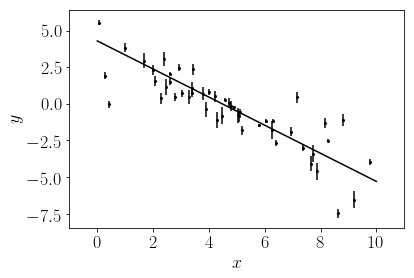

In [13]:
## Code taken from http://dfm.io/emcee/current/user/line/

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

errorbar(x, y, yerr=yerr, fmt='o', c='k', ms=2)
x_true = linspace(0, 10)
plot(x_true, x_true*m_true+b_true, c='k')
xlim(-1, 11)
xlabel('$x$')
ylabel('$y$')


## Defining the likelihood function with errors:
\begin{equation}
ln\ p(y|x, \sigma, m, b, f) = - \dfrac{1}{2}\sum_{n}\left[ \dfrac{(y_n - mx_n-b)^2}{s_n^2} + ln(2\pi s_n^2)\right]
\end{equation}

\begin{equation}
s_n^2 = \sigma_n^2 + f^2(mx_n + b)^2
\end{equation}

In [14]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [15]:
## Priors 

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf


In [16]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [20]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [32]:
import emcee

ndim, nwalkers = 3, 100
## -1, 4.48, -0.77 for m, b, lnf came from minimi
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

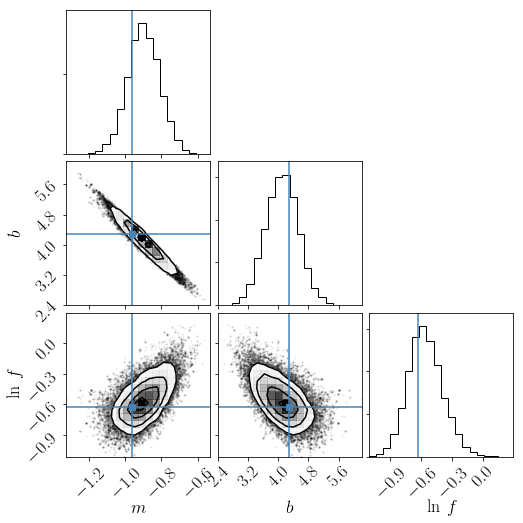

In [33]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])


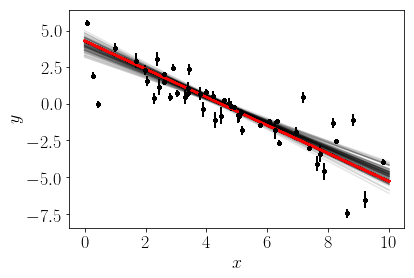

In [34]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plot(xl, m*xl+b, color="k", alpha=0.1)
    plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
    errorbar(x, y, yerr=yerr, fmt=".k")
xlabel('$x$')
ylabel('$y$')

In [36]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(m_mcmc, b_mcmc, f_mcmc)
print(m_true, b_true, f_true)

(-0.89872918365259957, 0.088612527409085207, 0.087366748949649575) (4.0929937442756845, 0.42995850843518468, 0.44062410107621197) (1.7615556373343637, 0.20686583474484177, 0.13694410538686941)
-0.9594 4.294 0.534
